In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Introduction

#### Aim

* Extract the HQ curves of the Heart Mate 3 device, for different RPMs. We constraint the curves to be polynomials of degree two.
* The coefficients of the curves will be reported in the `VAD2` model in the `Mathcard.mo` file.

#### Original HQ curve

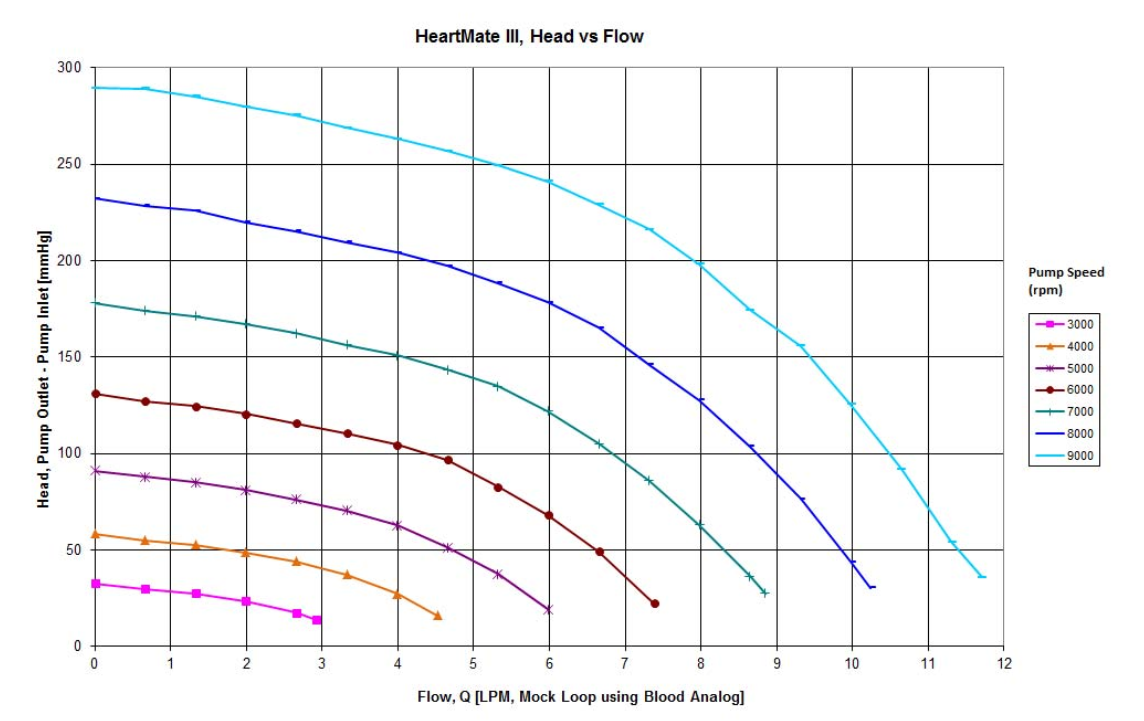

In [2]:
from IPython.display import Image
Image("../res/modelica/HQ-curve-HMIII.png")

# Curve coefficients

#### Report data points


In [3]:
# Dictionnary: RPM [int] -> data [list of xs [list] and ys[list] ]
# x = Q, y = P
data = {}

In [4]:
data[3000] = [
    [0.0, 1.0, 2.0, 2.9], # flow
    [32,  29, 23, 14],   # pressure
]

In [5]:
data[4000] = [
    [0.0, 2.0, 3.0, 4.5],
    [58,  49,  41,  16]
]

In [6]:
data[5000] = [
    [0.0, 2.0, 4.0, 6.0],
    [90,  80,  63,  19]
]

In [7]:
data[6000] = [
    [0.0, 2.0, 4.0, 6.0, 7.0, 7.4],
    [131, 120, 105, 70,  36,  22]
]

In [8]:
data[7000] = [
    [0.0, 2.0, 4.0, 5.0, 8.0],
    [177, 168, 150, 140, 63]
]

In [9]:
data[8000] = [
    [0.0, 2.0, 3.0, 5.0, 6.0, 8.0, 10.0],
    [232, 220, 211, 191, 178, 126, 43]
]

In [10]:
data[9000] = [
    [0.0, 2.0, 4.0, 6.0, 9.0, 10.0, 11.0],
    [290, 278, 263, 240, 164, 125,  72]
]

In [11]:
pickle.dump(data, open('../res/modelica/HM3-HQ-curve-data.bin', 'wb'))

#### Adjust units

The reported flow rate values are in $L/min$, while the model assumes $ml/s$. Thus we have to multiply every measure of $Q$ by $1000/60$.

In [12]:
for RPM in data:
    data[RPM] = np.array(data[RPM])
    data[RPM][0] = data[RPM][0] * 1000 / 60

## Fit polynomials


#### Procedure 

1. We reconstruct the HQ curve with the same axes as the original plot, as a mean of comparison
2. We reconstruct the HQ curve with **inverted axes**,
    * i.e. we perform polynomial regression with P as the input and Q as the output

#### Demo

[ 1.22017354  0.11388286 -0.0835141 ]


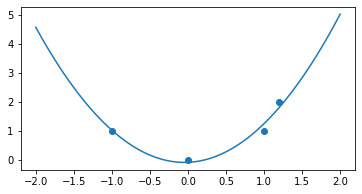

In [13]:
# Demo numpy.polyfit: f(x)=x^2
x = [-1,0,1, 1.2]
y = [1,0,1, 2]
coefs = np.polyfit(x, y, 2)
coefs # order: x^n, x^n-1, ..., x^1, x^0
print(coefs)
plt.subplots(1,1,figsize=(6,3))
plt.scatter(x, y)
x = np.linspace(-2, 2, 100)
plt.plot(x, np.polyval(coefs, x));

#### Compute coefficients of the polynomials

In [14]:
# Pressure in function of flow, dP(Q)
coefs = {}
# Flow in function of pressure, Q(dP)
coefs_rev = {}

for k in data:
    x = data[k][0]
    y = data[k][1]
    coefs[k] = np.polyfit(x, y, deg=2)
    coefs_rev[k] = np.polyfit(y, x, deg=2)

In [15]:
coefs

{3000: array([-6.41965766e-03, -5.96681677e-02,  3.19451487e+01]),
 4000: array([-7.71827707e-03,  2.58323632e-02,  5.77991851e+01]),
 5000: array([-7.65e-03,  7.50e-02,  8.90e+01]),
 6000: array([-8.36547556e-03,  1.92188722e-01,  1.28446363e+02]),
 7000: array([-7.16105290e-03,  1.20669563e-01,  1.75321748e+02]),
 8000: array([-7.83343555e-03,  2.41598816e-01,  2.25995876e+02]),
 9000: array([-7.58147075e-03,  2.83673726e-01,  2.83909077e+02])}

In [16]:
coefs_rev

{3000: array([-0.12205387,  3.00925926, 29.88636364]),
 4000: array([-4.88034086e-02,  1.84837429e+00,  5.77709507e+01]),
 5000: array([-2.45944445e-02,  1.29678032e+00,  8.40811870e+01]),
 6000: array([-1.21526186e-02,  8.19382568e-01,  1.07021624e+02]),
 7000: array([-1.37201995e-02,  2.16110226e+00,  5.14744398e+01]),
 8000: array([-5.53127232e-03,  7.05034781e-01,  1.43812490e+02]),
 9000: array([-4.29159884e-03,  8.05248158e-01,  1.41178920e+02])}

#### HQ plots

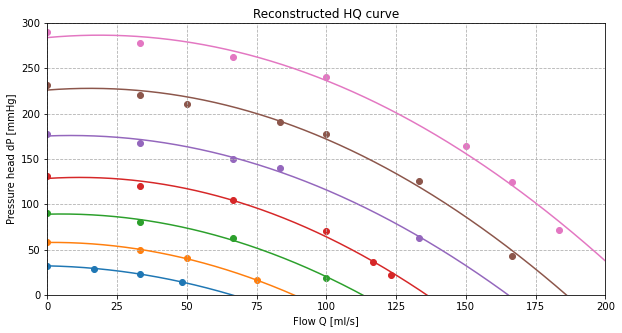

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
Qmax = 12 * 1000/60
Q = np.linspace(0, Qmax, 1000)

for RPM, coef in coefs.items():
    plt.scatter(data[RPM][0], data[RPM][1])
    plt.plot(Q, np.polyval(coef, Q))

plt.xlim(0, Qmax); plt.ylim(0, 300); plt.grid(ls='--');
plt.xlabel("Flow Q [ml/s]"); plt.ylabel("Pressure head dP [mmHg]");
plt.title("Reconstructed HQ curve");
plt.savefig('../res/modelica/HM3-HQ-curve-reconstructed.svg')

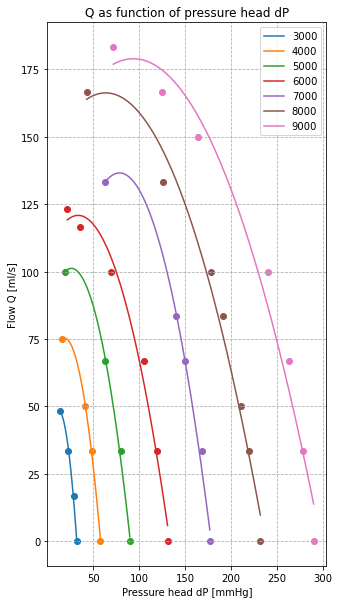

In [18]:
fig,ax = plt.subplots(1,1,figsize=(5, 10))
for RPM, coef in coefs_rev.items():
    pmin = min(data[RPM][1])
    pmax = max(data[RPM][1])
    dP = np.linspace(pmin, pmax, 1000)
    Q = np.polyval(coef, dP)
    plt.scatter(data[RPM][1], data[RPM][0])
    plt.plot(dP, Q, label=RPM)
    
plt.xlabel("Pressure head dP [mmHg]"); plt.ylabel("Flow Q [ml/s]"); plt.legend();
plt.grid(ls='--'); plt.title("Q as function of pressure head dP");

# Compare with the HQ curve of HM2

## Coefficients

Code provided from the `VAD` model in modelica:

```
Q = if RPM == 10000 then min(306.65 - 4.03 * dP + 0.0127 * dP ^ 2, 133) else if RPM == 9000 then min(245.16 - 3.6 * dP + 0.0119 * dP ^ 2, 116.667) else if RPM == 8000 then min(195.85 - 3.506 * dP + 0.0136 * dP ^ 2, 100) else 0;```


In [19]:
coef = {}
mins = {}

In [20]:
coef[10000] = [0.0127, -4.03, 306.65]
coef[9000]  = [0.0119, -3.6,  245.16]
coef[8000]  = [0.0136, -3.506, 195.85]

In [21]:
mins[10000] = 133
mins[9000] = 116.667
mins[8000] = 100

## Plotting without `min` applied

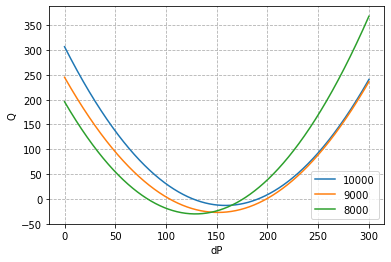

In [22]:
dP = np.linspace(0, 300, 1000)
plt.subplots(1,1,figsize=(6,4))

for elem in coef :
    Q = np.polyval(coef[elem], dP)
    plt.plot(dP, Q, label=elem)

plt.grid(ls='--'); plt.xlabel("dP"); plt.ylabel("Q");
plt.legend();

## Apply `min`

In [23]:
curves = {}
dP = np.linspace(0, 300, 1000)
for elem in coef :
    Q = np.polyval(coef[elem], dP)
    curves[elem] = Q

In [24]:
# Apply the min
curves_corrected = {}
for RPM in curves : 
    curves_corrected[RPM] = [ min(mins[RPM], q) for q in curves[RPM] ]

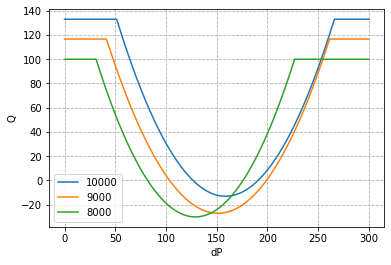

In [25]:
plt.subplots(1,1,figsize=(6,4))
dP = np.linspace(0, 300, 1000)
for RPM in curves_corrected:
    plt.plot(dP, curves_corrected[RPM], label=RPM)
    
plt.grid(ls='--'); plt.xlabel("dP"); plt.ylabel("Q");
plt.legend();

# Reconsider the range of values for `dP`

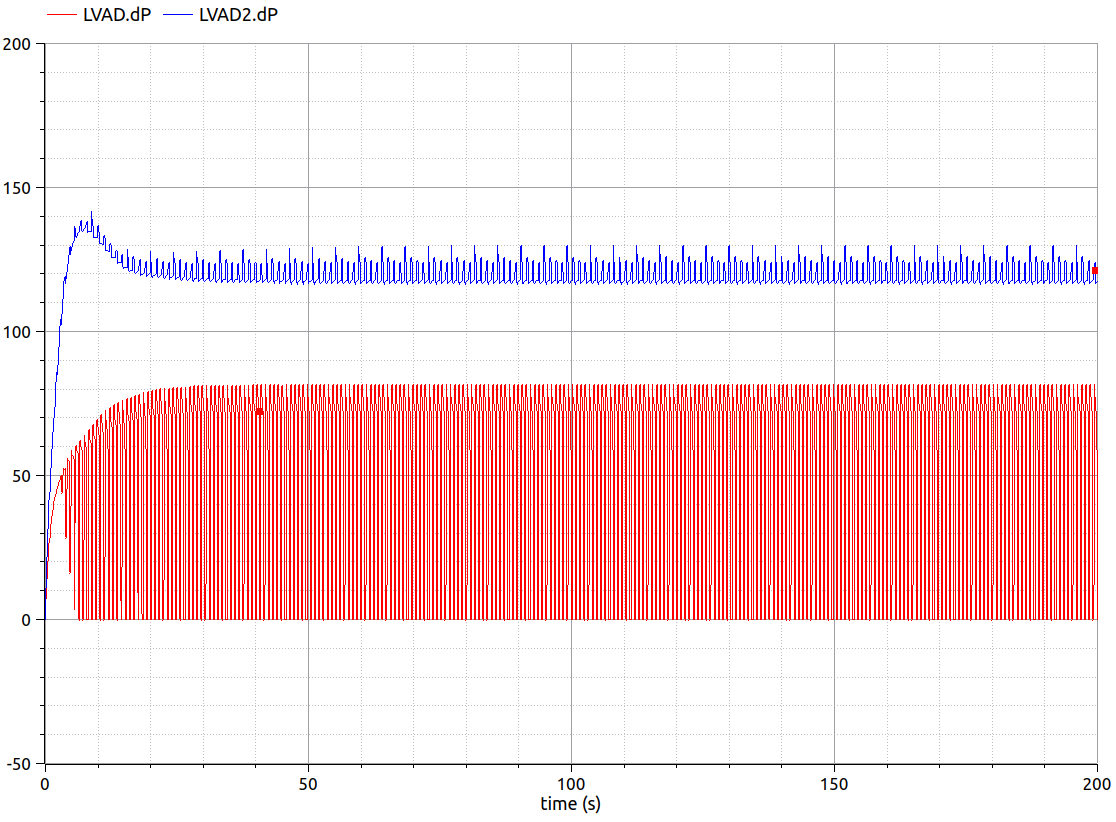

In [26]:
Image("../res/modelica/LVAD_dP.png")

The blue curve `LVAD2.dP` on top is for HM3, the red curve `LVAD.dP` is for HM2.

## HM2 HQ curve restricted in the observed dP range

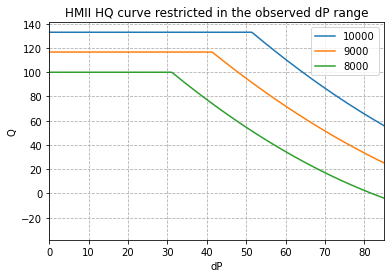

In [27]:
dPmax = 85
plt.subplots(1,1,figsize=(6,4))
for RPM in curves_corrected : 
    plt.plot(dP, curves_corrected[RPM], label=RPM)
    
plt.grid(ls='--'); plt.xlabel("dP"); plt.ylabel("Q");
plt.legend(); plt.xlim(0, dPmax);
plt.title("HMII HQ curve restricted in the observed dP range");

## HM3 HQ curve: Determine points where Q start to decrease

Given $Q = a_2 x^2 + a_1 x + a_0$, with x=dP, we calculate points where $Q'(x) = 0$, i.e. we calculate the x such that $x = - \frac{a_1}{2a_2}$

In [28]:
dP_critical = {}

for RPM in coefs_rev : 
    dP_critical[RPM] = - coefs_rev[RPM][1] / (2 * coefs_rev[RPM][0])
print(dP_critical)

{3000: 12.327586206896544, 4000: 18.936938447758124, 5000: 26.363277370964347, 6000: 33.71218154391415, 7000: 78.7562258994521, 8000: 63.73170049641598, 9000: 93.81680219082028}


RPM=3000, (dP_crit, Q_crit) = (12.328, 48.435)
RPM=4000, (dP_crit, Q_crit) = (18.937, 75.272)
RPM=5000, (dP_crit, Q_crit) = (26.363, 101.17)
RPM=6000, (dP_crit, Q_crit) = (33.712, 120.83)
RPM=7000, (dP_crit, Q_crit) = (78.756, 136.57)
RPM=8000, (dP_crit, Q_crit) = (63.732, 166.28)
RPM=9000, (dP_crit, Q_crit) = (93.817, 178.95)


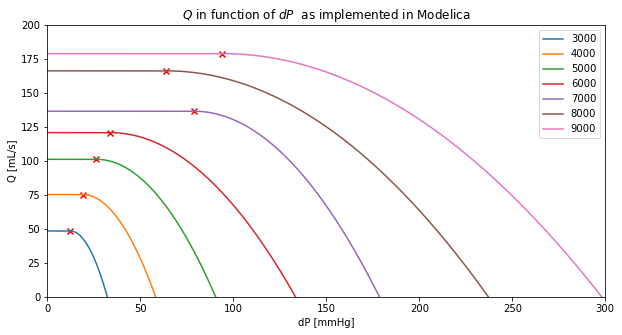

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

dPmax_HMIII = 300
dP = np.linspace(0, dPmax_HMIII, 1000)


for RPM in dP_critical : 
    # Compute Q
    Q = np.polyval(coefs_rev[RPM], dP)
    # Compute the points where Q begins to decrease
    a0, a1, a2 = coefs_rev[RPM][2], coefs_rev[RPM][1], coefs_rev[RPM][0]
    crit = dP_critical[RPM]
    q_crit = a0 + a1 * crit + a2 * crit ** 2
    # Once Q starts to decrease, set a constant
    Q = [ q if dP[i] >= crit else q_crit for i,q in enumerate(Q) ]
    
    print("RPM={}, (dP_crit, Q_crit) = ({:.5}, {:.5})".format(RPM, crit, q_crit))
    # Plot the cross marker
    plt.scatter(crit, q_crit, marker='x', color="red")
    ## Plot the curve
    plt.plot(dP, Q, label=RPM)
    
plt.xlim(0, dPmax_HMIII); plt.ylim(0, 200); plt.legend();
plt.xlabel("dP [mmHg]"); plt.ylabel("Q [mL/s]");
plt.title('$Q$ in function of $dP$  as implemented in Modelica')
plt.savefig('../res/modelica/HM3-HQ-curve-reversed.jpg')

# Article figure

In [30]:
from ipypublish import nb_setup
import seaborn as sns

In [31]:
plt = nb_setup.setup_matplotlib(usetex=False)
sns.set(style='whitegrid')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RPM=3000, (dP_crit, Q_crit) = (12.328, 48.435)
RPM=4000, (dP_crit, Q_crit) = (18.937, 75.272)
RPM=5000, (dP_crit, Q_crit) = (26.363, 101.17)
RPM=6000, (dP_crit, Q_crit) = (33.712, 120.83)
RPM=7000, (dP_crit, Q_crit) = (78.756, 136.57)
RPM=8000, (dP_crit, Q_crit) = (63.732, 166.28)
RPM=9000, (dP_crit, Q_crit) = (93.817, 178.95)


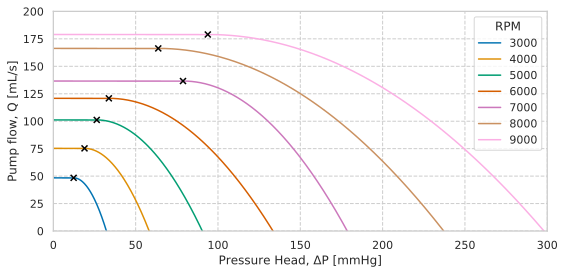

In [50]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

dPmax_HMIII = 300
dP = np.linspace(0, dPmax_HMIII, 1000)
colors = sns.color_palette('colorblind', n_colors=len(dP_critical))

for RPM, color in zip(dP_critical, colors) : 
    # Compute Q
    Q = np.polyval(coefs_rev[RPM], dP)
    # Compute the points where Q begins to decrease
    a0, a1, a2 = coefs_rev[RPM][2], coefs_rev[RPM][1], coefs_rev[RPM][0]
    crit = dP_critical[RPM]
    q_crit = a0 + a1 * crit + a2 * crit ** 2
    
    # Once Q starts to decrease, set a constant
    Q = [ q if dP[i] >= crit else q_crit for i,q in enumerate(Q) ]
    
    print("RPM={}, (dP_crit, Q_crit) = ({:.5}, {:.5})".format(RPM, crit, q_crit))
    # Plot the cross marker
    plt.scatter(crit, q_crit, marker='x', color="black", zorder=20)
    ## Plot the curve
    plt.plot(dP, Q, label=RPM, color=color)
    
plt.xlim(0, dPmax_HMIII); plt.ylim(0, 200); plt.legend();
plt.xlabel("Pressure Head, $\Delta$P [mmHg]"); plt.ylabel("Pump flow, Q [mL/s]");
plt.legend(title='RPM')
plt.grid(ls='--')
#plt.title('$Q$ in function of $dP$  as implemented in Modelica')
#plt.savefig('../res/modelica/HM3-HQ-curve-reversed.jpg')
plt.tight_layout()
plt.savefig('figs/LVAD-HQ-curve.eps')
plt.savefig('figs/LVAD-HQ-curve.pdf')

# Interpolate data at intermediate pump speed

## Reverse ramp test

The reverse ramp test consists of a progressive decrease in pump speed, by steps of 100 RPM. We want to calibrate DNNs for pump configurations between 6000 and 4000 RPMs (i.e. 21 configurations), and thus we need to interpolate curves at those intermediate speeds. 

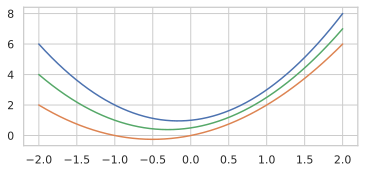

In [33]:
# Rationale: we can simply interpolate the polynomial coefficients
plt.figure(figsize=(6, 2.5))
p1 = [1.5, 0.5, 1]
p2 = [1, 1, 0]
x = np.linspace(-2, 2, 1000)
y1 = np.polyval(p1, x)
y2 = np.polyval(p2, x)
y = np.polyval([(e1+e2)/2 for e1,e2 in zip(p1, p2)], x)
plt.plot(x, y1, x, y2, x, y);

In [34]:
def interp_curve(coefs_dict, target_speed):
    """Returns the coefficients of the curve corresponding to target_speed, 
    obtained by linear interpolation between closest available data."""
    if target_speed in coefs_dict:
        return list(coefs_dict[target_speed])
    
    speeds = sorted(list(coefs_dict))
    if target_speed < speeds[0] or target_speed > speeds[-1]:
        print(f'Warning: Target speed {target_speed} out of bounds.')
        if target_speed < speeds[0]:
            lower, upper = speeds[:2]
        else:
            lower, upper = speeds[-2:]
    else:
        # Find closest RPM levels on which to perform interpolation
        lower = max(filter(lambda x: x < target_speed, speeds))
        upper = min(filter(lambda x: x > target_speed, speeds))
    
    relationships = [
        np.polyfit([lower, upper], [c1, c2], deg=1)
        for c1, c2 in zip(coefs_dict[lower], coefs_dict[upper])
    ]
    
    coeffs = [
        np.polyval(p, target_speed)
        for p in relationships
    ]
    
    return coeffs

In [35]:
interp_curve(coefs_rev, 3900)

[-0.05612845494535873, 1.9644627863830282, 54.98249201821029]

In [36]:
curves = {
    speed: interp_curve(coefs_rev, speed)
    for speed in range(4000, 6100, 100)
}
curves

{4000: [-0.04880340859996836, 1.8483742893967805, 57.77095072730439],
 4100: [-0.046382512186079944, 1.7932148926795675, 60.4019743546136],
 4200: [-0.04396161577219142, 1.7380554959623518, 63.032997981922904],
 4300: [-0.04154071935830288, 1.682896099245136, 65.66402160923222],
 4400: [-0.03911982294441435, 1.6277367025279204, 68.29504523654153],
 4500: [-0.036698926530525824, 1.5725773058107047, 70.92606886385084],
 4600: [-0.0342780301166373, 1.5174179090934885, 73.55709249116016],
 4700: [-0.03185713370274876, 1.4622585123762728, 76.18811611846947],
 4800: [-0.02943623728886023, 1.407099115659057, 78.81913974577878],
 4900: [-0.027015340874971705, 1.3519397189418414, 81.4501633730881],
 5000: [-0.024594444461083127, 1.2967803222246244, 84.08118700039745],
 5100: [-0.023350261873398517, 1.2490405467913113, 86.37523070555018],
 5200: [-0.022106079285713953, 1.201300771358, 88.66927441070288],
 5300: [-0.020861896698029375, 1.1535609959246886, 90.9633181158556],
 5400: [-0.01961771411

In [37]:
def compute_critical_values(coefs):
    xcrit = - coefs[1] / (2*coefs[0])
    ycrit = np.polyval(coefs, xcrit)
    return xcrit, ycrit

In [38]:
def plot_interp_curves(coefs_dict, speeds, dp_max=100, q_max=200):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    dp = np.linspace(0, dp_max, 1000)
    
    for s in speeds:
        coefs = interp_curve(coefs_dict, s)
        #dp_crit = - coefs[1] / (2*coefs[0])
        #q_crit = np.polyval(coefs, dp_crit)
        dp_crit, q_crit = compute_critical_values(coefs)
        q = np.polyval(coefs, dp)
        q = [
            q_ if dp[i] >= dp_crit else q_crit
            for i, q_ in enumerate(q)
        ]
        pltparams = ('-', dp_crit, q_crit, 'xr') \
                    if s in coefs_dict else ('k--', )
        if s in coefs_dict:
            ax.plot(dp, q, label=str(s))
            ax.plot(dp_crit, q_crit, 'xr')
        else:
            ax.plot(dp, q, 'k', lw=.5)
        #ax.plot(dp_crit, q_crit, 'o')
    
    ax.set_xlabel('Pump differential pressure [mmHg]')
    ax.set_ylabel('Pump blood flow [mL/s]')
    ax.axis(ymin=0, ymax=q_max)
    ax.legend(title='RPM')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


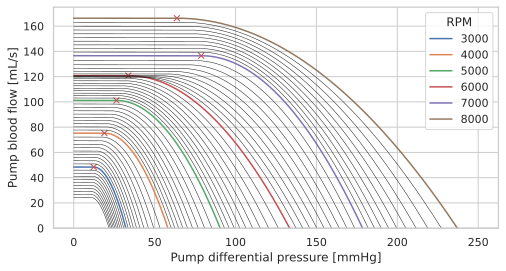

In [39]:
plot_interp_curves(coefs_rev, range(2000, 8100, 100), dp_max=250, q_max=175)
plt.savefig('figs/HQ-curves-interp.eps')
plt.savefig('figs/HQ-curves-interp.pdf', tight_layout=True)

## Format to modelica code

The HQ curves are hard-coded in Modelica, we provide here an automatic output from the previously computed coefficients of the curves. Here is an example of what the Modelica code looks like:

```
  Q = max(0, 
    if RPM == 3000 then 
      if dP < 12.33 then 48.43 
      else (-0.12205 * dP ^ 2) + 3.0093 * dP + 29.886 
    else if RPM == 4000 then 
      if dP < 18.94 then 75.27 
      else (-0.048803 * dP ^ 2) + 1.8484 * dP + 57.770 
    else if RPM == 5000 then 
      if dP < 26.36 then 101.17 
      else (-0.024594 * dP ^ 2) + 1.29678 * dP + 84.081 
    else if RPM == 6000 then 
      if dP < 33.71 then 120.83 
      else (-0.012153 * dP ^ 2) + 0.81934 * dP + 107.02 
    else if RPM == 7000 then 
      if dP < 78.76 then 136.57 
      else (-0.013720 * dP ^ 2) + 2.1611 * dP + 51.474 
    else if RPM == 8000 then 
      if dP < 63.73 then 166.28 
      else (-0.0055313 * dP ^ 2) + 0.70504 * dP + 143.71 
    else if dP < 93.82 then 178.95 
    else (-0.0042916 * dP ^ 2) + 0.80525 * dP + 141.18
  );
```



* there is an `if` for each RPM level
    * for each RPM level, we test whether `dP` is smaller than the critical value

In [40]:
def format_to_modelica(coefs_dict, indent='  ', error_value='10000'):
    def format_level(speed, coefs, indent):
        x_crit, y_crit = compute_critical_values(coefs)
        t = f'if RPM == {speed} then\n{indent}'
        t += 'if dP < {:.4} then {:.4}\n{}'.format(x_crit, y_crit, indent)
        t += 'else ( {:.6} * dP ^ 2 ) + {:.6} * dP + {:.6}'.format(*coefs)
        return t
    
    speeds = sorted(list(coefs_dict))
    # Special case: 1st if
    ifelse = format_level(speeds[0], coefs_dict[speeds[0]], indent)
    # Else if
    for s in speeds[1:]:
        ifelse += '\n' + 'else ' + format_level(s, coefs_dict[s], indent)
    # Last else: non-existing RPM value
    ifelse += '\nelse ' + error_value
    
    # Reindent
    ifelse = '\n'.join(indent*2 + line for line in ifelse.split('\n'))
    
    # Wrap around max function
    ifelse = indent + 'Q = max(0,\n' + ifelse + '\n' + indent + ');'
    
    return ifelse

In [41]:
to_modelica = {
    speed: interp_curve(coefs_rev, speed)
    for speed in range(2000, 8100, 100)
}
to_modelica.update(coefs_rev)
print(list(to_modelica))

[2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 9000]


In [42]:
print(format_to_modelica(to_modelica, error_value='0'))

  Q = max(0,
    if RPM == 2000 then
      if dP < 10.68 then 24.26
      else ( -0.195304 * dP ^ 2 ) + 4.17014 * dP + 2.00178
    else if RPM == 2100 then
      if dP < 10.78 then 26.65
      else ( -0.187979 * dP ^ 2 ) + 4.05406 * dP + 4.79024
    else if RPM == 2200 then
      if dP < 10.9 then 29.04
      else ( -0.180654 * dP ^ 2 ) + 3.93797 * dP + 7.57869
    else if RPM == 2300 then
      if dP < 11.02 then 31.44
      else ( -0.173329 * dP ^ 2 ) + 3.82188 * dP + 10.3672
    else if RPM == 2400 then
      if dP < 11.16 then 33.84
      else ( -0.166004 * dP ^ 2 ) + 3.70579 * dP + 13.1556
    else if RPM == 2500 then
      if dP < 11.31 then 36.25
      else ( -0.158679 * dP ^ 2 ) + 3.5897 * dP + 15.9441
    else if RPM == 2600 then
      if dP < 11.48 then 38.66
      else ( -0.151354 * dP ^ 2 ) + 3.47361 * dP + 18.7325
    else if RPM == 2700 then
      if dP < 11.66 then 41.09
      else ( -0.144029 * dP ^ 2 ) + 3.35752 * dP + 21.521
    else if RPM == 2800 then
      if dP < 